# Working with non-georeferenced datasets

We all want to use data _straight-out-of-the-box_.  In an ideal world, all Earth science data would be stored in self-describing datasets, be georeferenced, have attributes that allow data variables to be interpretted (e.g. units, standard names, cell methods, etc), and follow conventions accepted by the domaine of interest.  All a user needs to do is to open the dataset with their favourite tool and get right to the analysis.

Although more and more data producers are adopting good data practices, unfortunately, there are data sets that do not have the information users need to work with data.  These may be legacy datasets, datasets produced by colleagues and collaborators, and, annoyingly, datasets from data repositories.  



We'll use a dataset from https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0772_easegrids_anc_grid_info/ as an example.

In [1]:
#!wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies --no-check-certificate --auth-no-challenge=on -r --reject "index.html*" -np -e robots=off 

--2024-02-21 17:44:32--  https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0772_easegrids_anc_grid_info/NSIDC0772_LatLon_EASE2_N36km_v1.0.nc
Resolving daacdata.apps.nsidc.org (daacdata.apps.nsidc.org)... 128.138.135.43
Connecting to daacdata.apps.nsidc.org (daacdata.apps.nsidc.org)|128.138.135.43|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://urs.earthdata.nasa.gov/oauth/authorize?client_id=OeZxXA9CSNdsGKSltLUmIQ&response_type=code&redirect_uri=https%3A%2F%2Fdaacdata.apps.nsidc.org%2Foauth%2Fredirect_uri&state=aHR0cHM6Ly9kYWFjZGF0YS5hcHBzLm5zaWRjLm9yZy9wdWIvREFUQVNFVFMvbnNpZGMwNzcyX2Vhc2Vncmlkc19hbmNfZ3JpZF9pbmZvL05TSURDMDc3Ml9MYXRMb25fRUFTRTJfTjM2a21fdjEuMC5uYw [following]
--2024-02-21 17:44:33--  https://urs.earthdata.nasa.gov/oauth/authorize?client_id=OeZxXA9CSNdsGKSltLUmIQ&response_type=code&redirect_uri=https%3A%2F%2Fdaacdata.apps.nsidc.org%2Foauth%2Fredirect_uri&state=aHR0cHM6Ly9kYWFjZGF0YS5hcHBzLm5zaWRjLm9yZy9wdWIvREFUQVNFVFMvbnNpZGMwNzcyX

In [14]:
from pathlib import Path

import xarray as xr

In [15]:
datafile = Path("./NSIDC0772_LatLon_EASE2_N36km_v1.0.nc")
ds = xr.open_dataset(datafile)

In [16]:
ds

<xarray.Dataset> Size: 4MB
Dimensions:    (x: 500, y: 500)
Coordinates:
  * x          (x) float64 4kB -8.982e+06 -8.946e+06 ... 8.946e+06 8.982e+06
  * y          (y) float64 4kB 8.982e+06 8.946e+06 ... -8.946e+06 -8.982e+06
Data variables:
    crs        int32 4B ...
    latitude   (y, x) float64 2MB ...
    longitude  (y, x) float64 2MB ...
Attributes: (12/38)
    title:                     EASE2 Grid Ancillary Grid Information
    summary:                   This data set provides the latitude and longit...
    id:                        10.5067/GE8ET0MZ5ZVF
    metadata_link:             https://doi.org/10.5067/GE8ET0MZ5ZVF
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced and supported by the N...
    ...                        ...
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           1.0

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

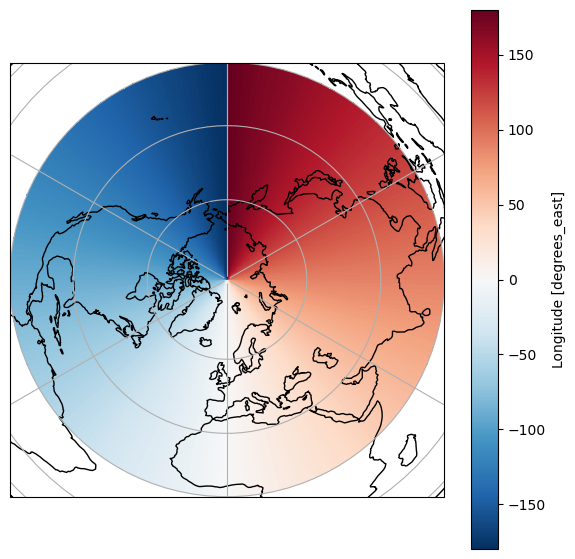

In [10]:
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=proj)

ax.coastlines()
ax.gridlines()
ds.longitude.plot(ax=ax)

In [34]:
test_ds = ds.drop_vars(["x", "y", "crs", "latitude"]).rename_dims({"y": "north_south", "x": "west_east"}).rename_vars({"longitude": "dummy"})
test_ds.attrs = {}
test_ds.dummy.attrs = {}
test_ds.to_netcdf(no_coord_file)

# What do we know about the data?

To work with a dataset we need to know what kind of data we have.  What is the variable.  What are the data units?  What kind of coordinate system is it in?  What is the coordinate reference system?  What are the coordinate axes?  What are the names, directions and units of the axes?

Finding this information might take some data sleuthing.  You may have to email the data producer.  In some cases, this kind of information might be in the file name, as in this case.  However, this is not really sufficient but it is something.

`NSIDC0772` is a dataset identifier for a dataset from the National Snow and Ice Data Center.  Some googling could lead us to [this page](https://nsidc.org/data/user-resources/help-center/guide-ease-grids#anchor-9).  Using elements from the filename and a little bit of digging might lead us to think that the data are in the EASE-Grid v2 based on the `EASE2`.  The `N` suggests it might be the EASE-Grid v2.0 North CRS.  `36km` looks like it might refer to the grid resolution.  

In [47]:
no_coord_file = Path("NSIDC0772_LatLon_EASE2_N36km_v1.0.no_coords.nc")
nc_ds = xr.open_dataset(no_coord_file)
nc_ds

<xarray.Dataset> Size: 2MB
Dimensions:  (north_south: 500, west_east: 500)
Dimensions without coordinates: north_south, west_east
Data variables:
    dummy    (north_south, west_east) float64 2MB ...

# What are the dimensions?

The dimensions are named `north_south` and `west_east`.  We could just use the data with these dimensions.  However, these are not the [defined names for the EASE-Grid v2.0](https://epsg.org/crs_6931/WGS-84-NSIDC-EASE-Grid-2-0-North.html?sessionkey=rhd3xkvg18).  Looking at the coordinate system entry we can see that the axes are X and Y.  The data are in a cartesian coordinate system, so renaming the coordinates to `x` and `y` makes sense.  Conforming to this standard will avoid confusing future users of the data.  It also a lot quicker to type `x` and `y`.

In `xarray` we can use `rename_dims` to change the dimension names.

In [48]:
nc_ds = nc_ds.rename_dims({"north_south": "y", "west_east": "x"})
nc_ds

<xarray.Dataset> Size: 2MB
Dimensions:  (y: 500, x: 500)
Dimensions without coordinates: y, x
Data variables:
    dummy    (y, x) float64 2MB ...

You can see that the dimension names have been changed both for the dimensions of the Dataset and the dimensions of the `dummy` data variable. 

# Add a Coordinate Reference System

Next, we need to add a Coordinate Reference System (CRS).  The CRS relates the projected coordinates, which normally are in meters, to the Earth.  See the [Georeferenced Data Guide](does_not_exist.html) for more information.

Looking at the grid definition for 36km grid in EASE-Grid v2.0 North, we can see that the EPSG code for this CRS is 6931.  We can use this to set the CRS.

:::[Note]
This is not strictly necessary for plotting or working with the data but it will help if we need to reproject the data and this information is preserved when we save the file.
:::

Because `rioxarray` was imported when we imported `xarray` we can use the `rio` accessor method `write_crs` to set the CRS.  This adds a spatial_ref coordinate variable.  Click on the attributes drop-down to see what information has been added.

In [53]:
nc_ds = nc_ds.rio.write_crs(6931)
nc_ds

<xarray.Dataset> Size: 2MB
Dimensions:      (y: 500, x: 500)
Coordinates:
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Data variables:
    dummy        (y, x) float64 2MB ...

You can also see the CRS using the `rio.crs` accessor method.  If no CRS has been set, this returns `None`. 

In [54]:
nc_ds.rio.crs

CRS.from_epsg(6931)

## Add coordinates

We've added the spatial reference system (SRS or CRS) but we now need to define the locations of each grid cell in the projected coordinates of the CRS.  

In [55]:
from affine import Affine

In [56]:
grid_cell_width = 36000.  # width of each grid cell in meters
grid_cell_height = -36000.  # height of each grid cell in meters
upper_left_x = -9000000.0
upper_left_y = 9000000.0
transform = Affine(grid_cell_width, 0.0, upper_left_x,
                   0.0, grid_cell_height, upper_left_y)

In [59]:
nc_ds = nc_ds.rio.write_transform(transform)
nc_ds

<xarray.Dataset> Size: 2MB
Dimensions:      (y: 500, x: 500)
Coordinates:
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Data variables:
    dummy        (y, x) float64 2MB ...

In [73]:
col = nc_ds.sizes['x']
row = nc_ds.sizes['y']
#row = np.arange(